In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition

storage = paths.storage.Storage("toy_retis.nc", mode="r")
print len(storage.samples)

31


In [7]:
print len(storage.samplesets)
print len(storage.samples)

21
31


In [8]:
ensembles=storage.ensembles[:]

In [13]:
tis=storage.transitions[0]
print tis

In [14]:
tis.ensembles = ensembles
for ensemble in tis.ensembles:
    ensemble.name = "I'face "+str(tis.ensembles.index(ensemble))

In [15]:
tis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 100) }
tis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [17]:
%%time
tis.all_statistics(samples=storage.samples, weights=None, force=True)

CPU times: user 2.25 s, sys: 386 ms, total: 2.64 s
Wall time: 2.59 s


In [18]:
tis.histograms

{'max_lambda': {<openpathsampling.ensemble.MinusInterfaceEnsemble at 0x110a09f50>: <openpathsampling.analysis.histogram.Histogram at 0x1109d40d0>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x110973b10>: <openpathsampling.analysis.histogram.Histogram at 0x110dd8b90>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x1109d6210>: <openpathsampling.analysis.histogram.Histogram at 0x110ec1910>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x1109d6510>: <openpathsampling.analysis.histogram.Histogram at 0x110e5ec90>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x1109d6b50>: <openpathsampling.analysis.histogram.Histogram at 0x110e43350>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x1109d6b90>: <openpathsampling.analysis.histogram.Histogram at 0x110e02a90>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x110a30190>: <openpathsampling.analysis.histogram.Histogram at 0x110e20710>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x110a35990>: <openpathsampl

In [19]:
for ens in tis.ensembles:
    myhist = tis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

ZeroDivisionError: float division by zero

ZeroDivisionError: float division by zero

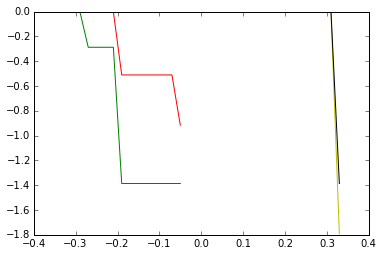

In [20]:
for ens in tis.ensembles:
    myhist = tis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), np.log(myhist.reverse_cumulative()))

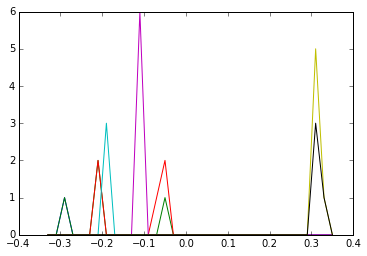

In [21]:
for ens in tis.ensembles:
    myhist = tis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

In [23]:
import openpathsampling.dynamics.toy as toy
pes = (toy.OuterWalls([1.0, 1.0], [0.0, 0.0]) + 
       toy.Gaussian(2.0, [1.0, 4.0], [0.0,1.0]) + 
       toy.Gaussian(2.0, [25.0, 1.0], [0.0, -1.0])
      )
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(pes)

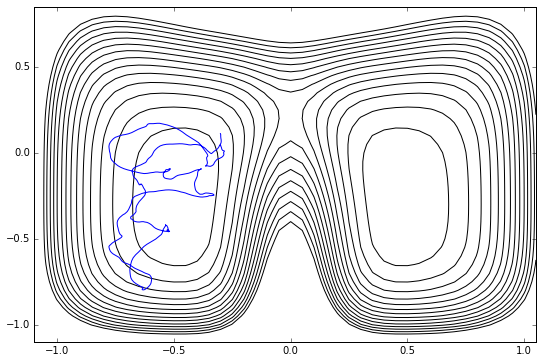

In [25]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == tis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,10)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [26]:
from openpathsampling.analysis.histogram import histograms_to_pandas_dataframe
df = histograms_to_pandas_dataframe(tis.histograms['max_lambda'].values(), fcn="reverse_cumulative").sort(axis=1)
df

ZeroDivisionError: float division by zero

In [27]:
from openpathsampling.analysis.wham import WHAM
wham = WHAM(cutoff=0.05)
wham.load_from_dataframe(df)
wham.clean_leading_ones()
wham_hist = wham.wham_bam_histogram()

NameError: name 'df' is not defined

In [28]:
wham_hist_list = [ (k, wham_hist[k]) for k in sorted(wham_hist.keys()) ]
plt.plot(list(zip(*wham_hist_list)[0]), list(zip(*wham_hist_list)[1]))

NameError: name 'wham_hist' is not defined

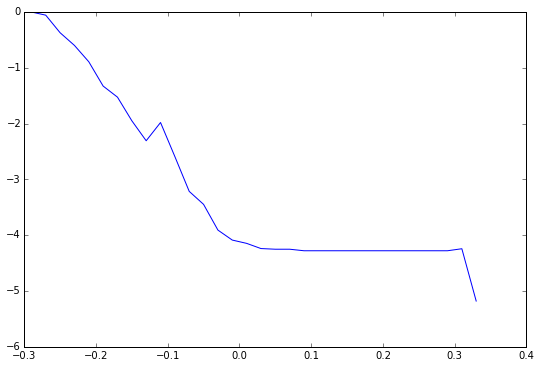

In [41]:
plt.plot(list(zip(*wham_hist_list)[0]), np.log(list(zip(*wham_hist_list)[1])))